<a href="https://colab.research.google.com/github/MothSleath/EmbeddedAI/blob/MothSleathBranch/TP_IA_EMBARQUEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
df = pd.read_csv('ai4i2020.csv')

# Display the head of the dataset
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

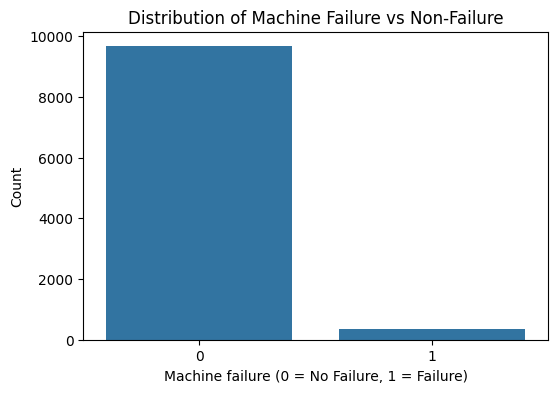

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Machine failure', data=df)
plt.title("Distribution of Machine Failure vs Non-Failure")
plt.xlabel("Machine failure (0 = No Failure, 1 = Failure)")
plt.ylabel("Count")
plt.show()

**ANALYSIS QUESTION:** What do you observe?

The distribution shows that there is a clear imbalance between observations of failed machines and those that are not. Specifically, most of the data corresponds to machines with no failure (value 0), while the proportion of failing machines (value 1) is much lower.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

This imbalance (class imbalance) risks biasing the model's learning. Specifically, an unadjusted model will tend to predominantly predict the absence of failure (the majority class), which can lead to a significant drop in recall and F1-score for the minority class (failure). Therefore, it will be necessary to implement rebalancing strategies (such as oversampling, undersampling, or adjusting class weights) to improve the prediction quality for the minority class.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

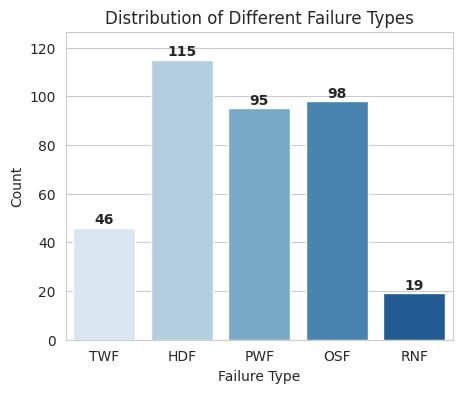

In [ ]:
# List of failure types
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

# Calculate the total number of failures for each type
failure_counts = df[failure_types].sum()

# Convert to a DataFrame to facilitate the use of hue
failure_counts_df = failure_counts.reset_index()
failure_counts_df.columns = ["failure_type", "count"]

# Create the bar chart with the hue variable
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
bars = sns.barplot(
    data=failure_counts_df,
    x="failure_type",
    y="count",
    hue="failure_type",
    dodge=False,
    palette="Blues"
)

# Hide the legend (unnecessary here because hue already corresponds to the x-axis)
plt.legend([], [], frameon=False)

# Add the exact values above each bar
for i, value in enumerate(failure_counts_df["count"]):
    plt.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontweight='bold')

plt.title("Distribution of Different Failure Types")
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.ylim(top=failure_counts_df["count"].max() * 1.1)  # To leave space for the annotations
plt.show()


**ANALYSIS QUESTION:** What do you observe?

By observing the bar chart, we note that HDF (Heat Dissipation Failure) is the most frequent failure type (115 occurrences). OSF (Overstrain Failure) and PWF (Power Failure) also have a high number of occurrences (98 and 95 respectively). TWF (Tool Wear Failure) and especially RNF (Random Failure) are less frequent, with 46 occurrences for TWF and 19 for RNF. This uneven distribution suggests that certain failure categories (HDF, OSF, PWF) are overrepresented compared to others (TWF, RNF), which may affect the modeling and the model's accuracy for the less frequent failures.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

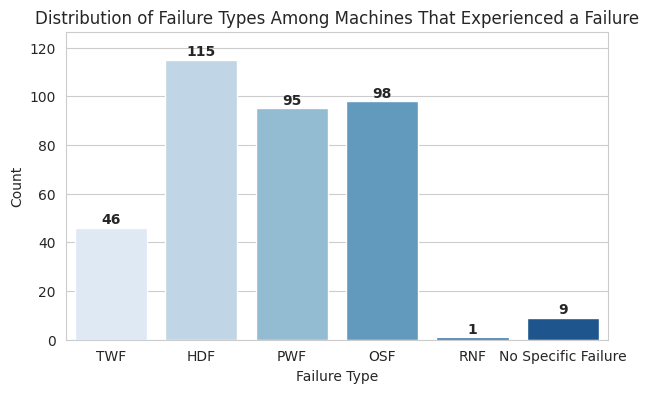

In [ ]:
# Filter only machines that experienced a failure
df_failures = df[df["Machine failure"] == 1].copy()

# List available failure types
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

# Calculate the total number of failures for each type
counts = df_failures[failure_types].sum()

# Calculate the number of machines that failed without a specific failure type
no_specific_failure_count = df_failures[
    (df_failures["TWF"] == 0) &
    (df_failures["HDF"] == 0) &
    (df_failures["PWF"] == 0) &
    (df_failures["OSF"] == 0) &
    (df_failures["RNF"] == 0)
].shape[0]

# Add the "No Specific Failure" category
counts = pd.concat([
    counts,
    pd.Series([no_specific_failure_count], index=["No Specific Failure"])
])

# Convert to DataFrame to use hue without warning
df_counts = counts.reset_index()
df_counts.columns = ["failure_type", "count"]

# Visualization
plt.figure(figsize=(7, 4))
sns.set_style("whitegrid")

bars = sns.barplot(
    data=df_counts,
    x="failure_type",
    y="count",
    hue="failure_type",
    dodge=False,      # No horizontal offset
    palette="Blues"   # Color palette
)

# Hide the legend (otherwise it duplicates the x-axis labels)
plt.legend([], [], frameon=False)

# Display the exact values above each bar
for i, value in enumerate(df_counts["count"]):
    plt.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontweight='bold')

plt.title("Distribution of Failure Types Among Machines That Experienced a Failure")
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.ylim(top=df_counts["count"].max() * 1.1)
plt.show()


**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Compared to the previous distribution that included all potential failures, this chart focuses solely on machines that actually failed (Machine failure == 1): HDF (Heat Dissipation Failure) remains the most frequent (115 occurrences), followed by OSF (Overstrain Failure) and PWF (Power Failure), while TWF (Tool Wear Failure) is less represented (46 occurrences) and RNF (Random Failure) is extremely rare (only 1 occurrence), suggesting possible misclassification; additionally, there are 9 machines that failed without any specific failure type activated, indicating unclassified or incomplete records, which overall underscores the need for improved classification or further information to better understand these failures.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

We will use as input: Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], and Tool wear [min], excluding UDI and Product ID as they do not provide useful information. For the output, we will first predict whether the machine fails (Machine failure, binary 0/1), and then we will specify the type of failure (TWF, HDF, PWF, OSF, RNF) in order to cover both the occurrence and the nature of the failure.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] # input features
Y = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']] # output labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # training (80%) / testing (20%)

print(f"X_train elements: {X_train.shape[0]}")
print(f"Y_train elements: {Y_train.shape[0]}")
print(f"X_test elements: {X_test.shape[0]}")
print(f"Y_test elements: {Y_test.shape[0]}")

X_train elements: 8000
Y_train elements: 8000
X_test elements: 2000
Y_test elements: 2000


**QUESTION** Code below the model architecture

In [ ]:
# deep learning model
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(Y_train.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,094 (12.09 KB)

 Trainable params: 3,094 (12.09 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0101 - loss: 10.5303 - val_accuracy: 0.8010 - val_loss: 0.1853
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7265 - loss: 0.1331 - val_accuracy: 0.6630 - val_loss: 0.0926
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6222 - loss: 0.0877 - val_accuracy: 0.8595 - val_loss: 0.0872
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5861 - loss: 0.0657 - val_accuracy: 0.9895 - val_loss: 0.0632
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5815 - loss: 0.0713 - val_accuracy: 0.4900 - val_loss: 0.0658
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5702 - loss: 0.0698 - val_accuracy: 0.9265 - val_loss: 0.0737
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5019 - loss: 0.0556 - val_accuracy: 0.0560 - val_loss: 0.0686
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4208 - loss: 0.0557 - val_accuracy: 0

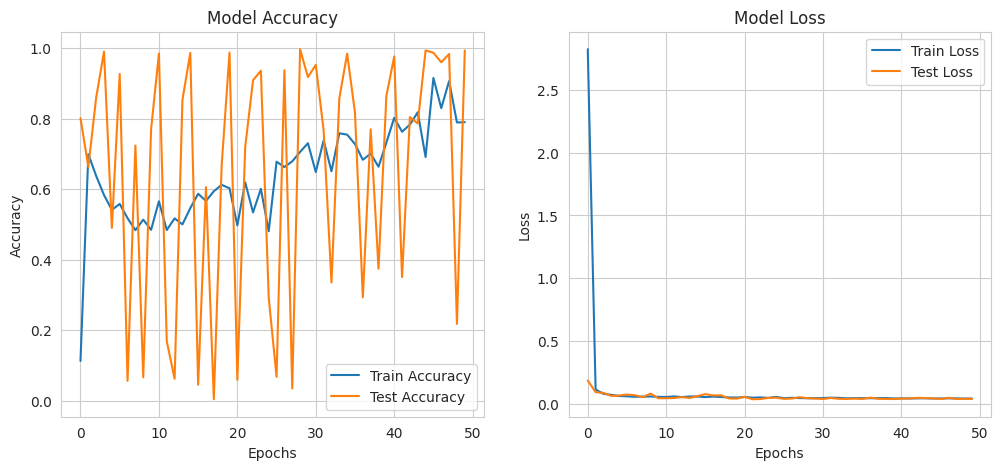

In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


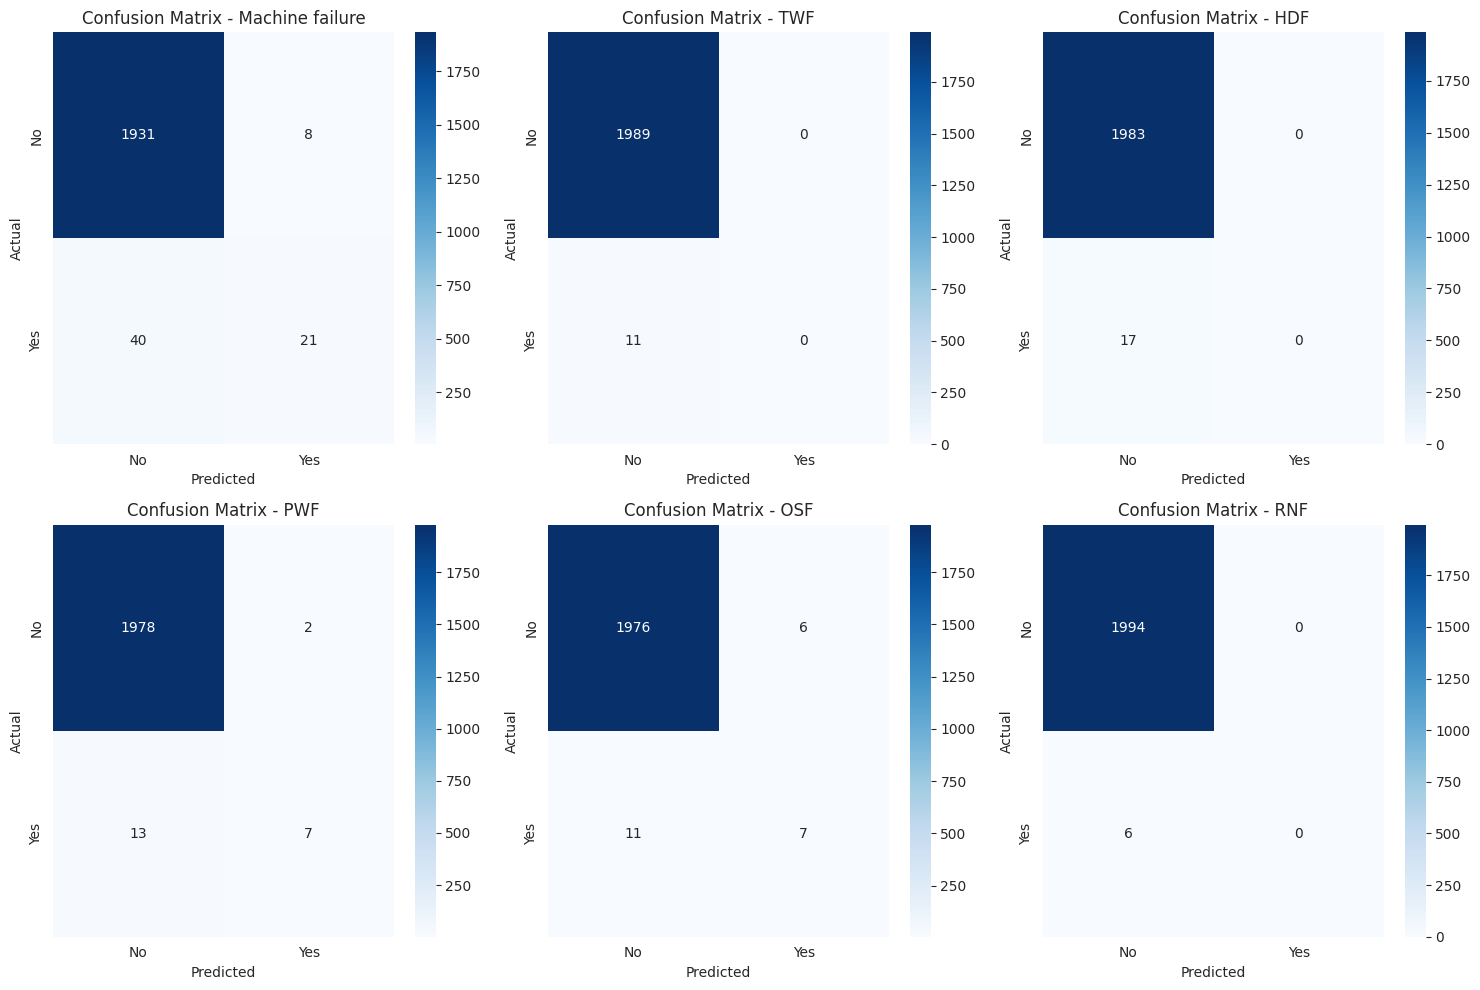

Classification Report:
                  precision    recall  f1-score   support

Machine failure       0.72      0.34      0.47        61
            TWF       0.00      0.00      0.00        11
            HDF       0.00      0.00      0.00        17
            PWF       0.78      0.35      0.48        20
            OSF       0.54      0.39      0.45        18
            RNF       0.00      0.00      0.00         6

      micro avg       0.69      0.26      0.38       133
      macro avg       0.34      0.18      0.23       133
   weighted avg       0.52      0.26      0.35       133
    samples avg       0.01      0.01      0.01       133



In [ ]:
# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# classification report
class_report = classification_report(
    Y_test, Y_pred,
    target_names=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
    zero_division=0
)

# confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(Y_test, Y_pred)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

failure_labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
for i, ax in enumerate(axes.flatten()):
    if i < len(failure_labels):
        sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=ax)
        ax.set_title(f'Confusion Matrix - {failure_labels[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


**ANALYSIS QUESTION** What do you observe? What can you conclude?


The confusion matrices reveal that the model is highly biased towards predicting non-failures, as it struggles to correctly identify actual failure cases. In categories like TWF, HDF, and RNF, the model never predicts a failure, even when failures are present in the dataset. This leads to high false negative rates, meaning the model fails to detect most real failures. While it does manage to correctly classify a few OSF and PWF failures, the majority of failures are still misclassified as non-failures.

The classification report also shows zero precision, recall, and F1-score for TWF, HDF, and RNF, meaning the model never predicted these labels correctly.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
# Definition of input and output variables
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
        'Torque [Nm]', 'Tool wear [min]']]
Y = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Concatenation of X and Y into a single dataframe and creation of a combined column
df_combined = pd.concat([X, Y], axis=1)
df_combined['combined_label'] = Y.astype(str).agg('_'.join, axis=1)

# Dataset rebalancing
# The target number per group is set to 1000 examples.
target_count = 1000
balanced_groups = []

# For each group (each unique case):
for label, group in df_combined.groupby('combined_label'):
    count = len(group)
    if count > target_count:
        # Random undersampling
        group_resampled = group.sample(n=target_count, random_state=42)
    elif count < target_count:
        # Random oversampling
        # For minority groups, we randomly duplicate examples to reach the threshold.
        repeats = target_count // count
        remainder = target_count % count
        group_resampled = pd.concat([group] * repeats + [group.sample(n=remainder, random_state=42)])
    else:
        group_resampled = group
    balanced_groups.append(group_resampled)

# Concatenation of all resampled groups
df_balanced = pd.concat(balanced_groups).reset_index(drop=True)

# Deletion of the temporary column "combined_label"
df_balanced.drop(columns=['combined_label'], inplace=True)

# Separation into X and Y variables in the balanced dataset
X_balanced = df_balanced[X.columns]
Y_balanced = df_balanced[Y.columns]

# Splitting into training (80%) and test (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, Y_balanced,
                                                    test_size=0.2, random_state=42)

# Display the number of elements in each set
print(f"X_train elements: {X_train.shape[0]}")
print(f"Y_train elements: {Y_train.shape[0]}")
print(f"X_test elements: {X_test.shape[0]}")
print(f"Y_test elements: {Y_test.shape[0]}")


X_train elements: 10400
Y_train elements: 10400
X_test elements: 2600
Y_test elements: 2600


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

I first wanted to use an undersampling method to reduce the majority classes, which prevented the other classes from being properly learned by the model. Then, I created realistic examples using SMOTE to multiply the minority classes.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [ ]:
# Model
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(Y_train.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,566 (6.12 KB)

 Trainable params: 1,566 (6.12 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7245 - loss: 0.2118 - val_accuracy: 0.7385 - val_loss: 0.2407
Epoch 2/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7379 - loss: 0.2072 - val_accuracy: 0.7446 - val_loss: 0.2168
Epoch 3/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7091 - loss: 0.2080 - val_accuracy: 0.7438 - val_loss: 0.2066
Epoch 4/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7455 - loss: 0.2043 - val_accuracy: 0.7358 - val_loss: 0.1980
Epoch 5/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7402 - loss: 0.1991 - val_accuracy: 0.7265 - val_loss: 0.2141
Epoch 6/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7343 - loss: 0.2028 - val_accuracy: 0.7396 - val_loss: 0.1934
Epoch 7/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7217 - loss: 0.2024 - val_accuracy: 0.7258 - val_loss: 0.2035
Epoch 8/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7248 - loss: 0.2026 - val_accuracy: 0.

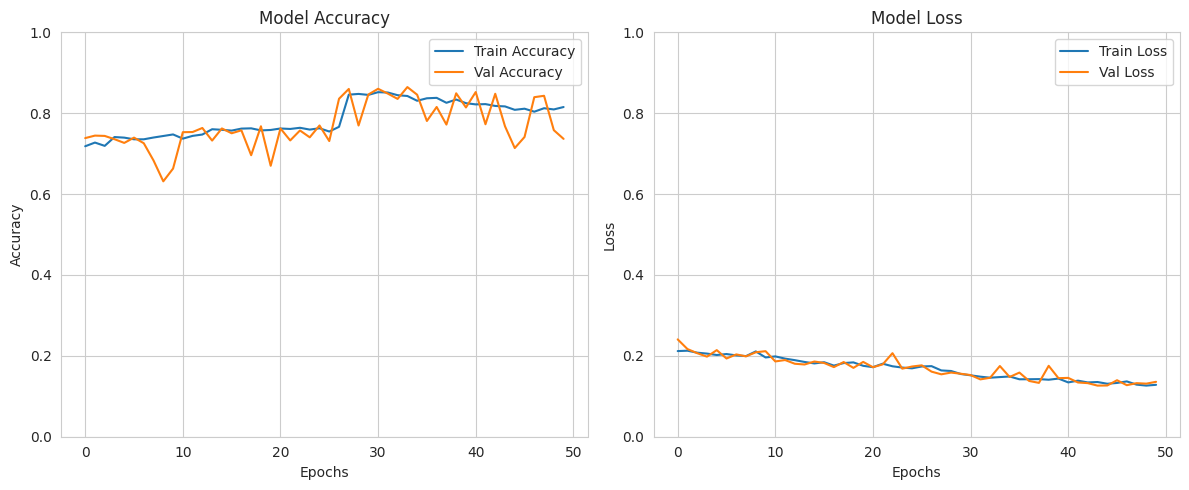

In [ ]:
# Training
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:

                 precision    recall  f1-score   support

Machine failure       0.97      0.92      0.94      2200
            TWF       0.85      0.98      0.91       757
            HDF       0.80      0.76      0.78       604
            PWF       0.99      1.00      1.00       812
            OSF       1.00      0.97      0.98       969
            RNF       0.61      0.74      0.66       390

      micro avg       0.91      0.92      0.91      5732
      macro avg       0.87      0.89      0.88      5732
   weighted avg       0.92      0.92      0.92      5732
    samples avg       0.77      0.78      0.77      5732



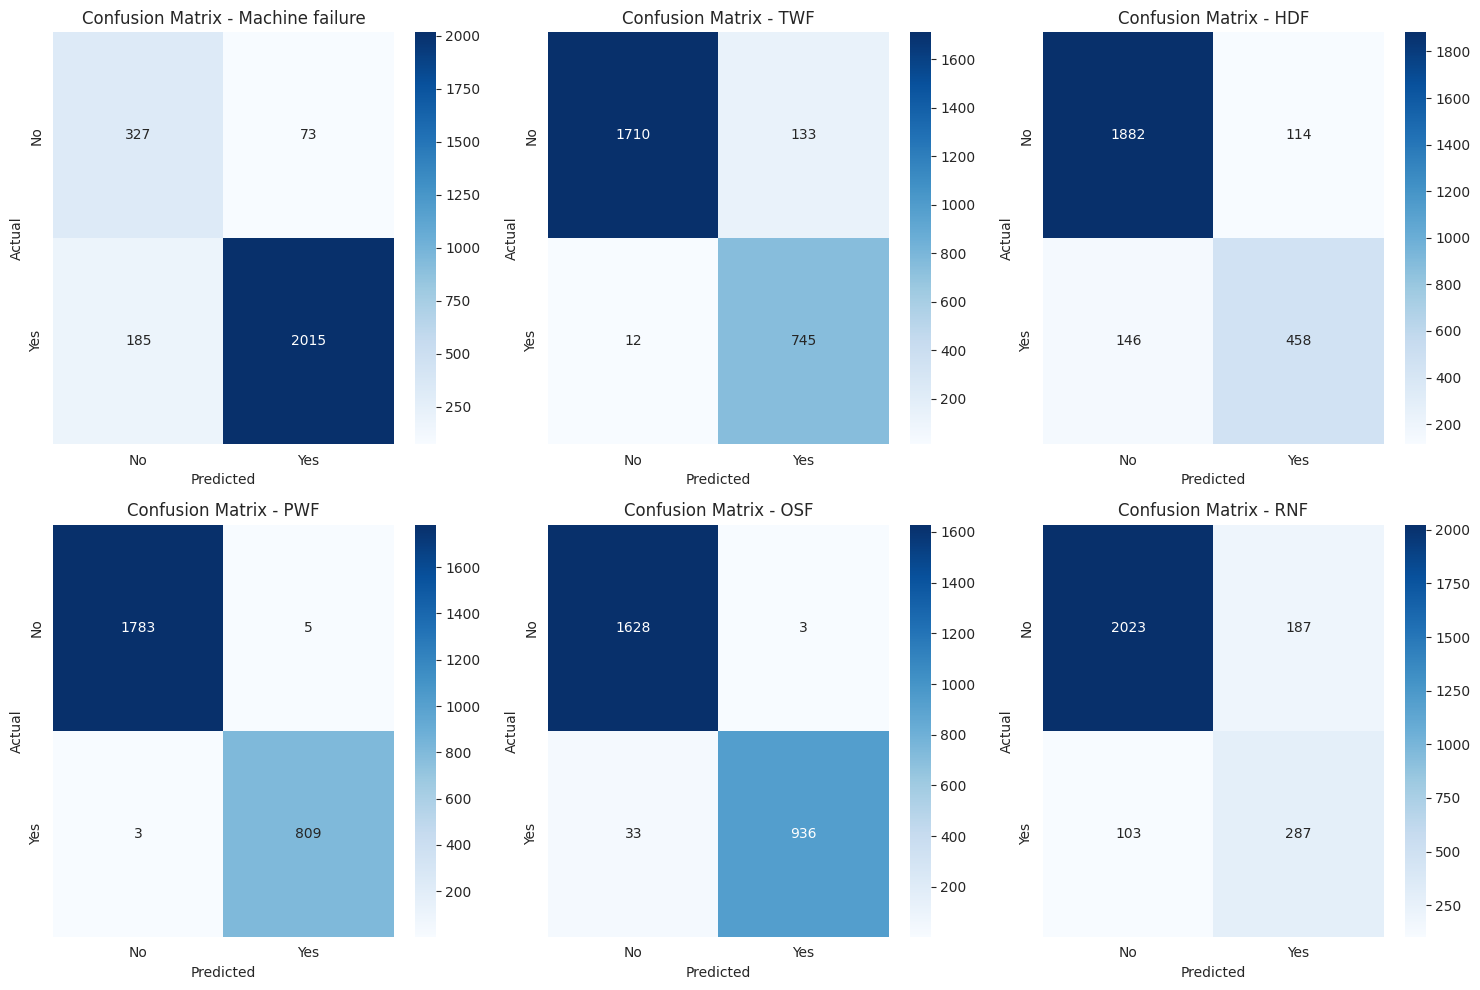

In [ ]:
# Predictions
Y_pred_proba = model.predict(X_test)
Y_pred = (Y_pred_proba > 0.5).astype(int)

labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
print("Classification Report:\n")
print(classification_report(Y_test, Y_pred, target_names=labels, zero_division=0))

# Confusion matrix
conf_matrices = multilabel_confusion_matrix(Y_test, Y_pred)

# Matrix plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    if i < len(labels):
        sns.heatmap(
            conf_matrices[i],
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            ax=ax
        )
        ax.set_title(f'Confusion Matrix - {labels[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Balancing the dataset significantly improved the model's ability to detect failures, particularly for minority classes that were previously ignored. The recall and F1-score for failure types (TWF, HDF, RNF) have increased, showing that the model is now better at recognizing different failure modes. However, signs of potential overfitting or instability remain, as validation accuracy and loss fluctuate, suggesting the model may still struggle with generalization. Further improvements, such as fine-tuning hyperparameters, adjusting class weights, or testing alternative oversampling techniques, could enhance performance. Overall, balancing the dataset made the model more reliable for predictive maintenance, but additional refinements are needed to optimize its robustness.